In [1]:
import os
import sys
import ast
from glob import glob
import json
import h5py
import multihist
import numpy as np
import pandas as pd
from multihist import Histdd
import collections
from scipy.interpolate import interp1d
import scipy.stats as sps
from itertools import product

import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
from matplotlib.colorbar import Colorbar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline

# Simple Darwin projections

knut.dundas.moraa@columbia.edu

This is a script to plot SI+SD projections using a _very simplified_ model of the eventual performance of a intrinsic-background-only hectotonne lXe TPC. 

If you are in XENON, you should be able to run https://github.com/kdund/darwin_proj_run (mail me about access)
The repo uses the usual XENON inference tools to construct a binned log-likelihood (unbinned becomes very unwieldy with the large number of events envisioned)

the analysis space is cS1 between 3 and 100 (97 bins), and cs2 between 200 and 10000 in 100 equi-log-bins 

Detector model: 
The response is taken using NEST (https://github.com/NESTCollaboration/nest), 
in particular the LUX_run03 detector configuration pre-set (https://github.com/NESTCollaboration/nest/blob/master/include/Detectors/LUX_Run03.hh) with g1 rounded to 0.12 to predict a rough response. 

The spectral model of SI and SD are taken from wimprates ( https://github.com/JelleAalbers/wimprates/)

Background spectra are taken to be the same as in the XENONnT projection paper, and only include intrinsic ER and NR backgrounds: 
#### Table of backgrounds: 
|Recoil Type|Name|Expectation/ty|Relative uncertainty|Spectrum file|
|--|------|---|---|--------|
|ER|events from B8|47|0.02|(SolarNeutrinoFEASpectrum.json)|
|ER|Xe136|24|0.1|Xe136Spectrum.json|
|NR|CEvNS events from B8 and HEP|5.5|0.02|Solar_CNNSSpectrum.json|
|NR|Atmospheric nus|0.04|0.1|Atm_CNNSSpectrum.json|
|NR|Diffuse SN nus|0.008|0.1|DSN_CNNSSpectrum.json|


In [19]:
class loginterpolator:
    def __init__(self,x,y):
        self.logf = interp1d(np.log10(x),np.log10(y),bounds_error=False, fill_value=0.)
    def __call__(self,x):
        return 10**self.logf(np.log10(x))

In [2]:
# SR1 style (see https://github.com/XENON1T/SR1Results/blob/master/Plots/likelihood_bands_and_models.ipynb)
# with a few additions

params = {
    'font.family': 'serif',
    'font.size' : 20, 'axes.titlesize' : 24, 'axes.labelsize' : 24, 'axes.linewidth' : 2,
    # ticks
    'xtick.labelsize' : 22, 'ytick.labelsize' : 22, 'xtick.major.size' : 16, 'xtick.minor.size' : 8,
    'ytick.major.size' : 16, 'ytick.minor.size' : 8, 'xtick.major.width' : 2, 'xtick.minor.width' : 2,
    'ytick.major.width' : 2, 'ytick.minor.width' : 2, 'xtick.direction' : 'in', 'ytick.direction' : 'in',
    # markers
    'lines.markersize' : 12, 'lines.markeredgewidth' : 3, 'errorbar.capsize' : 8, 'lines.linewidth' : 3,
    #'lines.linestyle' : None, 'lines.marker' : None,
    'savefig.bbox' : 'tight', 'legend.fontsize' : 24, 
    'backend': 'Agg', 'mathtext.fontset': 'dejavuserif', 'legend.frameon' : False,
    'figure.facecolor':'w',
    'figure.figsize':(9,9),
    #pad
    'axes.labelpad':12,
    # ticks
    'xtick.major.pad': 6,   'xtick.minor.pad': 6,   
    'ytick.major.pad': 3.5, 'ytick.minor.pad': 3.5,
    # colormap
    #'image.cmap':'viridis'
}
plt.rcParams.update(params)
#%config InlineBackend.figure_formats = {'png', 'retina'}
#matplotlib.rcParams['figure.dpi'] = 300

In [116]:
def get_limitangle(xlim,ylim,figlim=plt.rcParams["figure.figsize"]):
    dlx = np.log10(xlim[1])-np.log10(xlim[0])
    dly = np.log10(ylim[1])-np.log10(ylim[0])
    dlx,dly
    
    tant = (figlim[1]*dlx/dly)/(figlim[0])
    return 180.*np.arctan(tant)/np.pi

In [236]:
class curve:
    def __init__(self,x,y,extend_to_highmass = True,blotnull = True):
        highmass = 100000
        if extend_to_highmass:
            yy = np.concatenate([np.array(y),[y[-1]*highmass / x[-1] ]]  )
            xx = np.concatenate([np.array(x),[highmass]])
        else:
            yy = y
            xx = x
        if blotnull: 
            xx = xx[0.<yy]
            yy = yy[0.<yy]
        self.logfunc = interp1d(np.log10(xx),np.log10(yy),bounds_error = False, fill_value = np.inf)
    def set_band(self,x,ys,extend_to_highmass = True,blotnull=True):
        highmass = 100000
        band_logfuncs = []
        for y in ys:
            if extend_to_highmass:
                yy = np.concatenate([np.array(y),[y[-1]*highmass / x[-1] ]]  )
                xx = np.concatenate([np.array(x),[highmass]])
            else:
                yy = y
                xx = x
            if blotnull: 
                xx = xx[0.<yy]
                yy = yy[0.<yy]
            band_logfuncs.append(interp1d(np.log10(xx),np.log10(yy),bounds_error = False, fill_value = np.inf))
        self.band_logfuncs = band_logfuncs
        
    def plot(self,x=None,**kwargs):
        if x == None:
            x = np.linspace(self.logfunc.x[0],self.logfunc.x[-1],300)
        else:
            x = np.log10(x)
        plt.plot(10.**x,10.**self.logfunc(x),**kwargs)
    def plot_band(self,x=None,idown=0,iup=-1,**kwargs):
        if x == None:
            x = np.linspace(self.logfunc.x[0],self.logfunc.x[-1],300)
        else:
            x = np.log10(x)
        plt.fill_between(10.**x,10.**self.band_logfuncs[idown](x),10.**self.band_logfuncs[iup](x),**kwargs)
    def plot_nufog(self,x=None,idown=0,iup=-1,mults = np.logspace(0,-5,6),**kwargs):
        if x == None:
            x = np.linspace(self.logfunc.x[0],self.logfunc.x[-1],300)
        else:
            x = np.log10(x)
        for mult in mults:
            plt.fill_between(10.**x,10.**self.band_logfuncs[idown](x),mult*10.**self.band_logfuncs[iup](x),**kwargs)
        

### Load darwin & nt projection into curves:

In [237]:
f = np.load("resources/darwin_projection_curves.npz",allow_pickle=True)

#nu-floor
nuf = f["nuf"].item()
nuf_masses = f["nuf_masses"]

simple_nu_floors = {n:curve(nuf_masses, nuf[n]) for n in ["SI","SD_n_central","SD_p_central"]}
for k in simple_nu_floors.keys():
    simple_nu_floors[k].set_band(nuf_masses,[1e-60*np.ones(len(nuf_masses)), nuf[k] ])
## darwin 
sensi_livetimes = f["sensi_livetimes"]
sensi_masses = f["sensi_masses"]
sigmas = [-2,-1,0,1,2]
interactions = ["SI","SD_p_central","SD_n_central","WIMPPion"]
darwin_curves = dict()
sensiss = f["sensiss"].item()
for interaction in interactions:
    for i,livetime in enumerate(sensi_livetimes): 
        sensis = sensiss[interaction][0.]
        if interaction =="WIMPPion":
            sensis = sensiss[interaction][0.]/(365.*1000.)
        sensi = sensis[i,:]
        key = interaction,livetime
        darwin_curves[key] = curve(sensi_masses, sensi*1e-45)
        sensips = [sensiss[interaction][sigma][i,:]*1e-45 for sigma in sigmas]
        darwin_curves[key].set_band(sensi_masses, sensips)
        

#nt proj?
ntproj = f["ntproj"]
nt_masses = ntproj[0]
nt_sensi = ntproj[1]["ulmed"]
nt_si_curve = curve(nt_masses, nt_sensi*1e-45)
      




/Users/kdund/miniconda3/envs/xenon_pax/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater
/Users/kdund/miniconda3/envs/xenon_pax/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/Users/kdund/miniconda3/envs/xenon_pax/lib/python3.4/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in greater
/Users/kdund/miniconda3/envs/xenon_pax/lib/python3.4/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in greater


In [238]:
f = np.loadtxt("resources/sd_p_only_limit.csv",delimiter=",")
xe1t_sdp_limit = curve(f[:,0],f[:,1])
f = np.loadtxt("resources/sd_n_only_limit.csv",delimiter=",")
xe1t_sdn_limit = curve(f[:,0],f[:,1])
f = np.loadtxt("resources/xe1t_si_limit.csv",delimiter=",")
xe1t_si_limit = curve(f[:,0],f[:,1])
f = np.loadtxt("resources/s2only_si_limit.csv",delimiter=",")
xe1t_sis2_limit = curve(f[:,0],f[:,1])
f = np.loadtxt("resources/xe1t_pion_limit.csv",delimiter=",")
xe1t_pion_limit = curve(f[:,0],f[:,1])

In [239]:
f = np.loadtxt("resources/lz_15d3_si_1sided_proj.csv",delimiter=",")
lz_si_curve = curve(f[:,0],f[:,1] )

In [240]:
f = np.loadtxt("resources/pico_sdp_webplotdigitized.csv",delimiter=",")
pico_sdp_curve = curve(f[:,0],f[:,1])

In [241]:
f = np.loadtxt("resources/billard_nufloor.csv",delimiter=",")
billard_curve = curve(f[:,0],f[:,1],blotnull=False)
billard_curve.set_band(f[:,0],[1e-60*np.ones(len(f[:,1])), f[:,1]]  , blotnull=False)

# SI plot

In [242]:
xecolor = "dodgerblue"
lzcolor = "darkorange"
darwincolor = "seagreen"
picocolor = "crimson"

/Users/kdund/miniconda3/envs/xenon_pax/lib/python3.4/site-packages/ipykernel/__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


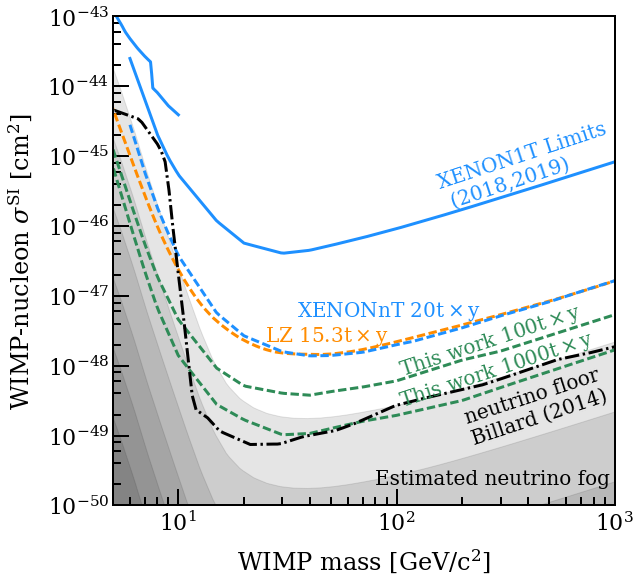

In [257]:
plt.clf()
xlim = [5,1000]
ylim = [1e-50,1e-43]
tangle = get_limitangle(xlim, ylim)
xe1t_si_limit.plot(linestyle="-",color=xecolor)
xe1t_sis2_limit.plot(np.linspace(1,10,100),linestyle="-",color=xecolor)

lz_si_curve.plot(linestyle="--",color=lzcolor)
nt_si_curve.plot(linestyle="--",color=xecolor)

darwin_curves["SI",100].plot(linestyle="--" ,color=darwincolor)
darwin_curves["SI",1000].plot(linestyle="--",color=darwincolor)
#darwin_curves["SI",100].plot_band(idown=1,iup=3)

#simple_nu_floors["SI"].plot_band(idown=0,iup=1,color="k",alpha=0.1)
billard_curve.plot(linestyle="-.",color="k",alpha=1)
simple_nu_floors["SI"].plot_nufog(color="k",alpha=0.1)

plt.text(150,1e-45,"XENON1T Limits\n (2018,2019)",size=20,color=xecolor,rotation=tangle)
plt.text(25,0.22e-47,"LZ $15.3\\mathrm{t}\\times\\mathrm{y}$",size=20,color=lzcolor,rotation=0.)
plt.text(35,0.5e-47,"XENONnT $20\\mathrm{t}\\times\\mathrm{y}$",size=20,color=xecolor,rotation=0.)
plt.text(100,5e-48,"This work $100\\mathrm{t}\\times\\mathrm{y}$",size=20,color=darwincolor,rotation=tangle)
plt.text(100,2e-48,"This work $1000\\mathrm{t}\\times\\mathrm{y}$",size=20,color=darwincolor,rotation=tangle)
plt.text(200,0.3e-48,"neutrino floor\nBillard (2014)",size=20,color="k",rotation=tangle)
plt.text(80,0.02e-48,"Estimated neutrino fog",size=20,color="k",rotation=0)
#plt.text(100,1e-46,"XENON1T Limits\n (2018,2019)",size=20,color=xecolor,rotation=tangle)

plt.xlim(xlim)
plt.ylim(ylim)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("WIMP mass [$\mathrm{GeV/c^2}$]")
#plt.ylabel("WIMP-nucleon $\sigma$ [$\mathrm{cm^2}$]")
plt.ylabel("WIMP-nucleon $\sigma^\\mathrm{SI}$ [$\mathrm{cm^2}$]")
plt.savefig("fig_simplified_projection_si.png")
plt.savefig("fig_simplified_projection_si.pdf")
plt.show()

In [244]:
10**xe1t_si_limit.logfunc(np.log10(50))

5.2576990679507954e-47

In [245]:
0.052*175

9.1

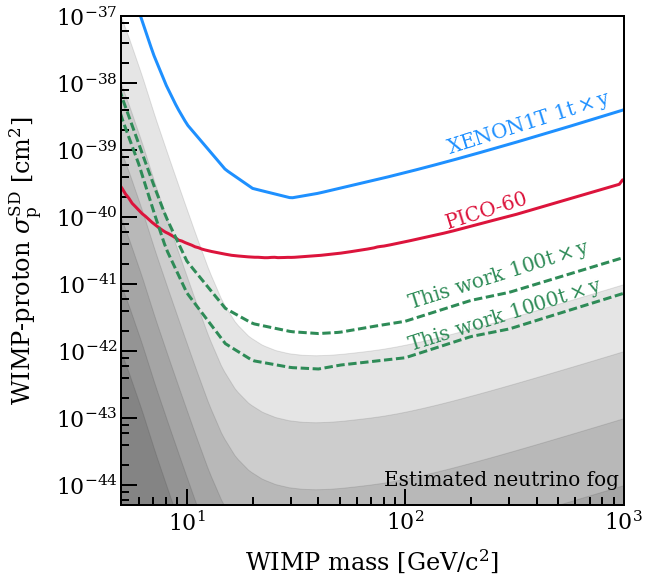

In [247]:
plt.clf()
xlim = [5,1000]
ylim = [0.5e-44,1e-37]
tangle = get_limitangle(xlim, ylim)
pico_sdp_curve.plot(linestyle="-",color=picocolor)
#xe1t_sdn_limit.plot(linestyle="-",color=xecolor)
xe1t_sdp_limit.plot(linestyle="-",color=xecolor)
#xe1t_sis2_limit.plot(np.linspace(1,10,100),linestyle="-",color=xecolor)

#lz_si_curve.plot(linestyle="--",color=lzcolor)
#nt_si_curve.plot(linestyle="--",color=xecolor)

darwin_curves["SD_p_central",100].plot(linestyle="--" ,color=darwincolor)
darwin_curves["SD_p_central",1000].plot(linestyle="--",color=darwincolor)
#darwin_curves["SD_n_central",100].plot(linestyle="--" ,color=darwincolor)
#darwin_curves["SD_n_central",1000].plot(linestyle="--",color=darwincolor)
#darwin_curves["SI",100].plot_band(idown=1,iup=3)

simple_nu_floors["SD_p_central"].plot_nufog(color="k",alpha=0.1)
#simple_nu_floors["SD_n_central"].plot_band(idown=0,iup=1,color="k",alpha=0.1)
#billard_curve.plot_band(idown=0,iup=1,color="k",alpha=0.1)

plt.text(150,0.5e-38,"XENON1T $1\\mathrm{t}\\times\\mathrm{y}$",size=20,color=xecolor,rotation=tangle)
plt.text(150,1.6e-40,"PICO-60",color=picocolor,rotation=tangle)
#plt.text(40,0.6e-47,"LZ $15.3\\mathrm{t}\\times\\mathrm{y},$",size=20,color=lzcolor,rotation=tangle)
#plt.text(3.5*40,6*0.6e-47,"XENONnT $20\\mathrm{t}\\times\\mathrm{y}$",size=20,color=xecolor,rotation=tangle)
plt.text(100,3e-41,"This work $100\\mathrm{t}\\times\\mathrm{y}$",size=20,color=darwincolor,rotation=tangle)
plt.text(100,0.8e-41,"This work $1000\\mathrm{t}\\times\\mathrm{y}$",size=20,color=darwincolor,rotation=tangle)
plt.text(80,0.1e-43,"Estimated neutrino fog",size=20,color="k",rotation=0)

plt.xlim(xlim)
plt.ylim(ylim)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("WIMP mass [$\mathrm{GeV/c^2}$]")
plt.ylabel("WIMP-proton $\sigma^\\mathrm{SD}_\\mathrm{p}$ [$\mathrm{cm^2}$]")
plt.savefig("darwin_simplified_projection_sdp.png")
plt.savefig("darwin_simplified_projection_sdp.pdf")
plt.show()

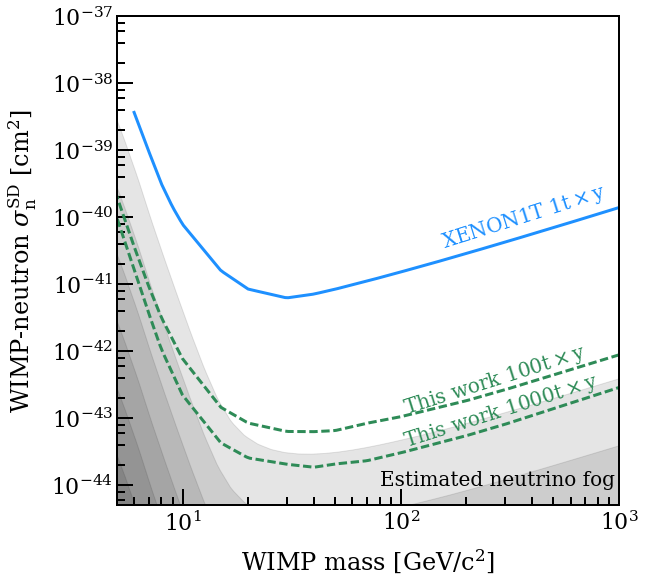

In [259]:
plt.clf()
xlim = [5,1000]
ylim = [0.5e-44,1e-37]
tangle = get_limitangle(xlim, ylim)
#pico_sdp_curve.plot(linestyle="-",color=picocolor)
xe1t_sdn_limit.plot(linestyle="-",color=xecolor)
#xe1t_sdp_limit.plot(linestyle="-",color=xecolor)
#xe1t_sis2_limit.plot(np.linspace(1,10,100),linestyle="-",color=xecolor)

#lz_si_curve.plot(linestyle="--",color=lzcolor)
#nt_si_curve.plot(linestyle="--",color=xecolor)

#darwin_curves["SD_p_central",100].plot(linestyle="--" ,color=darwincolor)
#darwin_curves["SD_p_central",1000].plot(linestyle="--",color=darwincolor)
darwin_curves["SD_n_central",100].plot(linestyle="--" ,color=darwincolor)
darwin_curves["SD_n_central",1000].plot(linestyle="--",color=darwincolor)
#darwin_curves["SI",100].plot_band(idown=1,iup=3)

simple_nu_floors["SD_n_central"].plot_nufog(color="k",alpha=0.1)
#simple_nu_floors["SD_n_central"].plot_band(idown=0,iup=1,color="k",alpha=0.1)
#billard_curve.plot_band(idown=0,iup=1,color="k",alpha=0.1)

plt.text(150,2e-40,"XENON1T $1\\mathrm{t}\\times\\mathrm{y}$",size=20,color=xecolor,rotation=tangle)
#plt.text(150,1.6e-40,"PICO-60",color=picocolor,rotation=tangle)
#plt.text(40,0.6e-47,"LZ $15.3\\mathrm{t}\\times\\mathrm{y},$",size=20,color=lzcolor,rotation=tangle)
#plt.text(3.5*40,6*0.6e-47,"XENONnT $20\\mathrm{t}\\times\\mathrm{y}$",size=20,color=xecolor,rotation=tangle)
plt.text(100,8e-43,"This work $100\\mathrm{t}\\times\\mathrm{y}$",size=20,color=darwincolor,rotation=tangle)
plt.text(100,3e-43,"This work $1000\\mathrm{t}\\times\\mathrm{y}$",size=20,color=darwincolor,rotation=tangle)
plt.text(80,0.1e-43,"Estimated neutrino fog",size=20,color="k",rotation=0)

plt.xlim(xlim)
plt.ylim(ylim)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("WIMP mass [$\mathrm{GeV/c^2}$]")
plt.ylabel("WIMP-neutron $\sigma^\\mathrm{SD}_\\mathrm{n}$ [$\mathrm{cm^2}$]")
plt.savefig("fig_simplified_projection_sdn.png")
plt.savefig("fig_simplified_projection_sdn.pdf")
plt.show()

##  Contour

In [219]:
f_20 = np.load("resources/contour_wimpmass_20.npz")
f_100 = np.load("resources/contour_wimpmass_100.npz")
contour_masses = f_20["wimp_masses"]
contour_mus = f_20["nominal_signal_expectations"]
nse_curve = curve(contour_masses, 1e-45*1000./contour_mus)
nse_interpolator = loginterpolator(contour_masses, contour_mus)
allsegs_20 = f_20["allsegs"]
allsegs_100 = f_100["allsegs"]

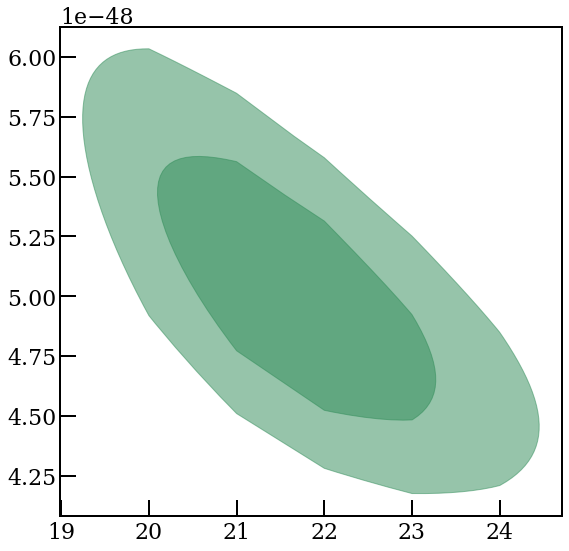

In [220]:
plt.clf()
for seg in allsegs_20:
    for sseg in seg:
        cx = sseg[:,0]
        cy = sseg[:,1]
        plt.fill(cx,1e-45 * cy / nse_interpolator(cx) ,color=darwincolor,alpha=0.5)
plt.show()
    

In [221]:
colors = ["seagreen","cyan"]

/Users/kdund/miniconda3/envs/xenon_pax/lib/python3.4/site-packages/ipykernel/__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


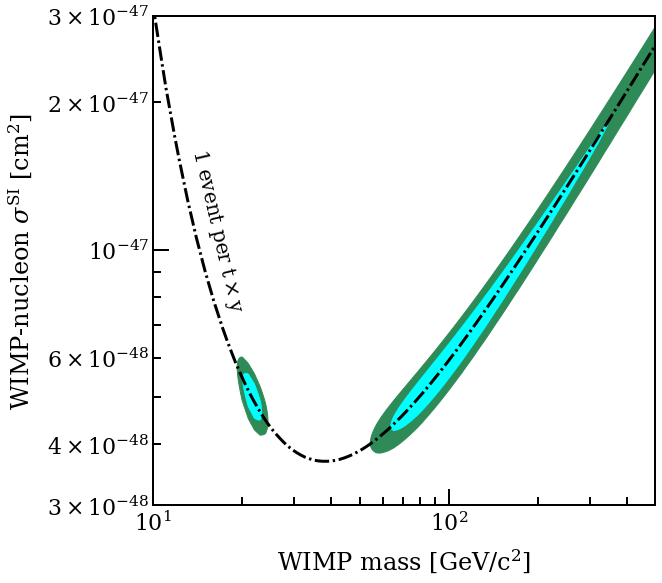

In [222]:
plt.clf()
xlim = [10,500]
ylim = [3e-48,0.3e-46]
tangle = get_limitangle(xlim, ylim)
xe1t_si_limit.plot(linestyle="-",color=xecolor)
xe1t_sis2_limit.plot(np.linspace(1,10,100),linestyle="-",color=xecolor)



for allseg in [allsegs_100, allsegs_20]:
    for seg,color in zip(reversed(allseg),colors):
        for sseg in seg:
            cx = sseg[:,0]
            cy = sseg[:,1]
            plt.fill(cx,1e-45 * cy / nse_interpolator(cx) ,color=color,alpha=1.)


#lz_si_curve.plot(linestyle="--",color=lzcolor)
#nt_si_curve.plot(linestyle="--",color=xecolor)

#darwin_curves["SI",100].plot(linestyle="--" ,color=darwincolor)
#darwin_curves["SI",1000].plot(linestyle="--",color=darwincolor)
#darwin_curves["SI",100].plot_band(idown=1,iup=3)

#simple_nu_floors["SI"].plot_band(idown=0,iup=1,color="k",alpha=0.1)
nse_curve.plot(linestyle="-.",color="k")
#billard_curve.plot_band(idown=0,iup=1,color="k",alpha=0.1)

#plt.text(100,0.6e-45,"XENON1T Limits\n (2018,2019)",size=20,color=xecolor,rotation=tangle)
#plt.text(25,0.22e-47,"LZ $15.3\\mathrm{t}\\times\\mathrm{y}$",size=20,color=lzcolor,rotation=0.)
#plt.text(35,0.5e-47,"XENONnT $20\\mathrm{t}\\times\\mathrm{y}$",size=20,color=xecolor,rotation=0.)
#plt.text(100,5e-48,"DARWIN $100\\mathrm{t}\\times\\mathrm{y}$",size=20,color=darwincolor,rotation=tangle)
#plt.text(100,2e-48,"DARWIN $1000\\mathrm{t}\\times\\mathrm{y}$",size=20,color=darwincolor,rotation=tangle)
#plt.text(200,0.05e-48,"neutrino floor\nBillard (2014)",size=20,color="k",rotation=0)
#plt.text(100,1e-46,"XENON1T Limits\n (2018,2019)",size=20,color=xecolor,rotation=tangle)
plt.text(13,1.5e-47,"1 event per $\\mathrm{t}\\times\\mathrm{y}$ ",rotation=-77)

plt.xlim(xlim)
plt.ylim(ylim)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("WIMP mass [$\mathrm{GeV/c^2}$]")
#plt.ylabel("WIMP-nucleon $\sigma$ [$\mathrm{cm^2}$]")
plt.ylabel("WIMP-nucleon $\sigma^\\mathrm{SI}$ [$\mathrm{cm^2}$]")
plt.savefig("fig_simplified_contour_si.png")
plt.savefig("fig_simplified_contour_si.pdf")
plt.show()

## Pion 

In [223]:
darwin_curves.keys()

dict_keys([('WIMPPion', 1000), ('SI', 100), ('SD_n_central', 1000), ('SD_p_central', 1000), ('WIMPPion', 200), ('SD_n_central', 200), ('WIMPPion', 100), ('SI', 1000), ('SD_p_central', 200), ('SD_p_central', 100), ('SI', 200), ('SD_n_central', 100)])

In [224]:
a = darwin_curves["WIMPPion",100]

In [225]:
a.logfunc(2)

array(-47.073056352903755)

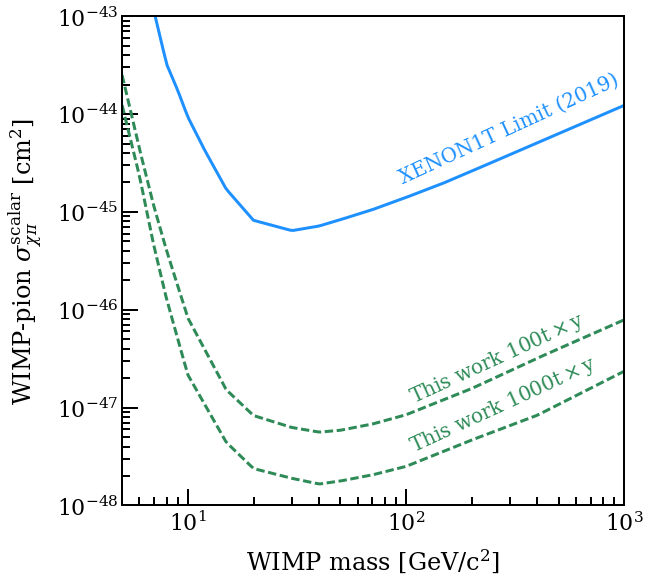

In [234]:
plt.clf()
xlim = [5,1000]
ylim = [1e-48,1e-43]
tangle = get_limitangle(xlim, ylim)
xe1t_pion_limit.plot(linestyle="-",color=xecolor)

darwin_curves["WIMPPion",100].plot(linestyle="--" ,color=darwincolor)
darwin_curves["WIMPPion",1000].plot(linestyle="--",color=darwincolor)
#darwin_curves["SI",100].plot_band(idown=1,iup=3)

#simple_nu_floors["SI"].plot_band(idown=0,iup=1,color="k",alpha=0.1)

plt.text(90,2e-44,"XENON1T Limit (2019)",size=20,color=xecolor,rotation=tangle)
plt.text(100,7e-47,"This work $100\\mathrm{t}\\times\\mathrm{y}$",size=20,color=darwincolor,rotation=tangle)
plt.text(100,2.5e-47,"This work $1000\\mathrm{t}\\times\\mathrm{y}$",size=20,color=darwincolor,rotation=tangle)

plt.xlim(xlim)
plt.ylim(ylim)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("WIMP mass [$\mathrm{GeV/c^2}$]")
#plt.ylabel("WIMP-nucleon $\sigma$ [$\mathrm{cm^2}$]")
plt.ylabel("WIMP-pion $\sigma^\\mathrm{scalar}_{\chi\pi}$ [$\mathrm{cm^2}$]")
plt.savefig("fig_simplified_projection_pion.png")
plt.savefig("fig_simplified_projection_pion.pdf")
plt.show()

In [ ]:
 #
 #
 #
 #
 #

['uls', 'dls', 'bestfit_nulls', 'bestfit_frees']

In [113]:
f =  np.load("resources/cached_ul_151m_wimppion_SR10.npz")
uls = f["uls"].item()
ulm = np.array(sorted(uls.keys()))
ulss = np.array([uls[m]*1e-45 for m in ulm])
np.savetxt("resources/xe1t_pion_limit.csv",np.vstack([ulm,ulss]).T,delimiter=",")